In [1]:
import numpy as np
import matplotlib.pyplot as plt

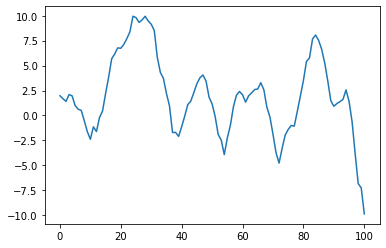

In [175]:
def gen_ar1(a, T, s = 1):
    X = np.zeros(T)
    X[0] = np.random.normal(0, s / np.sqrt((1 - a ** 2)))

    for t in range(1, T):
        X[t] = a * X[t - 1] + np.random.normal(0, s)
        
    return X

def gen_ar_noise(a, T, noises):
    X = np.zeros(T)
    X[0] = np.random.normal(0, np.std(noises) / np.sqrt((1 - a ** 2)))

    for t in range(1, T):
        X[t] = a * X[t - 1] + noises[t]
        
    return X

def exp_cost_ar(a_true, a_est, s = 1):
    return s + (a_true - a_est) ** 2 * 1 / (1 - a_true ** 2)

def exp_cost_model(a_true, a_est, a, s = 1):
    return s + (a_true - a_est) ** 2 * (1 / (1 - a ** 2) + a_true)

a = 0.8
T = 101
noises = gen_ar1(a, T)
X = gen_ar_noise(a, T, noises)
plt.plot(X)

In [3]:
def compute_bias(features, labels):
    
    T = np.shape(labels)[0]
    bias = []
    
    # for each sample
    for i in range(T):
        # split data
        features_del, labels_del = np.delete(features, i), np.delete(labels, i)
        features_test, labels_test = features[i], labels[i]

        # train on del set
        coefs = 1 / (features_del @ features_del.T) * features_del @ labels_del

        # train on test set
        ## full random variable
        bias.append(coefs * features_test * (2 * labels_test - coefs * features_test))
        
        ## part of random variable with non-zero mean
        # bias.append(-(coefs * features_test) ** 2)
        
        ## second part of second moment decomposition
        # bias.append(coefs * features_test)
    
    return np.mean(bias)

def cv_1d(features, labels):
    
    T = np.shape(labels)[0]
    cv_scores = []
    cv_scores_2 = []
    
    # for each sample
    for i in range(T):
        # split data
        features_del, labels_del = np.delete(features, i), np.delete(labels, i)
        features_test, labels_test = features[i], labels[i]

        # train on del set
        coefs = 1 / (features_del @ features_del.T) * features_del @ labels_del

        # train on test set
        cv_scores.append((labels_test - features_test * coefs) ** 2)
        res = labels_test
        cv_scores_2.append(coefs * features_test * (2 * res - coefs * features_test))
        
    
    return np.mean(np.array(cv_scores)), np.mean(np.array(cv_scores_2))

def cv_nd(features, labels):
    
    T = np.shape(labels)[0]
    cv_scores = []
    
    # for each sample
    for i in range(T):
        # split data
        features_del, labels_del = np.delete(features, i, axis = 1), np.delete(labels, i)
        features_test, labels_test = features[:, i], labels[i]

        # train on del set
        coefs = np.linalg.inv(features_del @ features_del.T) @ features_del @ labels_del

        # test on test set
        cv_scores.append(((labels_test - features_test @ coefs) ** 2))

    return np.mean(np.array(cv_scores))

a_est = 1 / (np.dot(X_1[:-1], X_1[:-1].T)) * X_1[:-1] @ X_1[1:]

print(f"CV Using X1:\t\t{round(cv_1d(X_1[1:], X_1[:-1])[0], 4)}. MSE on X1:\t{1 / T * np.linalg.norm(X_1[1:] - a_est * X_1[:-1], 2) ** 2}")
print(f"CV Using true a:\t{1 / (T - 1) * np.linalg.norm(X_1[1:] - a * X_1[:-1], 2) ** 2}.")

NameError: name 'X_1' is not defined

In [4]:
a = 0.8
T = 101
X_1 = gen_ar1(a, T)

a_est = 1 / (np.dot(X_1[:-1], X_1[:-1].T)) * X_1[:-1] @ X_1[1:]

print(f"CV Using X1:\t\t{round(cv_1d(X_1[1:], X_1[:-1])[0], 4)}.\tMSE on X1:\t{1 / (T - 1) * np.linalg.norm(X_1[1:] - a_est * X_1[:-1], 2) ** 2}")
print(f"CV Using true a:\t{round(1 / (T - 1) * np.linalg.norm(X_1[1:] - a * X_1[:-1], 2) ** 2, 4)}.")

CV Using X1:		0.8776.	MSE on X1:	0.8125774121997048
CV Using true a:	0.8198.


### AR(1) With Offset
We assume the data is generated as $$X_t = aX_{t - 1} + b + \varepsilon_t.$$
We generate and try the following hypothesis:
$$H_0: a = 0, b \in \mathbb{R}, \qquad H_1: a \neq 0, b \in \mathbb{R}.$$
Under $H_0$, we have that $$\underset{b \in \mathbb{R}}{\arg \min} \frac{1}{T - 1} \sum_{t = 2}^T\left\lVert X_t - \hat{X}_t\right\rVert_2^2 = \underset{b \in \mathbb{R}}{\arg \min} \frac{1}{T - 1} \sum_{t = 2}^T\left\lVert X_t - b\right\rVert_2^2 = \frac{1}{T - 1}\sum_{t = 2}^T X_t.$$
So, $\hat{b}$ is simply the mean of the labels, so $\overline{X_{-1}}$, the mean of $X$ excluding the first element.

Under $H_1$, we have that $$\underset{a, b \in \mathbb{R}}{\arg \min} \frac{1}{T - 1} \sum_{t = 2}^T\left\lVert X_t - \hat{X}_t\right\rVert_2^2 = \underset{a, b \in \mathbb{R}}{\arg \min} \frac{1}{T - 1} \sum_{t = 2}^T\left\lVert X_t - (a X_{t-1} + b)\right\rVert_2^2 = \frac{1}{T - 1}\sum_{t = 2}^T X_t.$$

We have that $$\hat{b} = \frac{1}{T - 1}\sum_{t = 2}^T X_t, \qquad \hat{a} = \frac{\sum_{t = 2}^T\left(X_t - \hat{b}\right)\left(X_{t - 1} - \hat{b}\right)}{\sum_{t = 1}^{T - 1}\left(X_t - \hat{b}\right)\left(X_t - \hat{b}\right)}$$

In [5]:
def cv_H0(features, labels, X):
    
    T = np.shape(labels)[0]
    cv_scores = []
    
    # for each sample
    for i in range(T):
        # split data
        features_del, labels_del = np.delete(features, i), np.delete(labels, i)
        features_test, labels_test = features[i], labels[i]
        X_del = np.delete(X, i + 1)
        mean = np.mean(features_del)

        features_m = features_del - mean
        labels_m = labels_del - mean
        
        # train on del set
        coefs = 0

        # train on test set
        cv_scores.append((labels_m - features_m * coefs) ** 2)        
    
    return np.mean(np.array(cv_scores))

def cv_H1(features, labels, X):
    
    T = np.shape(labels)[0]
    cv_scores = []
    
    # for each sample
    for i in range(T):
        # split data
        features_del, labels_del = np.delete(features, i), np.delete(labels, i)
        features_test, labels_test = features[i], labels[i]
        X_del = np.delete(X, i)
        mean = np.mean(features_del)

        features_m = features_del - mean
        labels_m = labels_del - mean
        
        # train on del set
        coefs = 1 / (features_m @ features_m.T) * features_m @ labels_m

        # train on test set
        cv_scores.append((labels_m - features_m * coefs) ** 2)        
    
    return np.mean(np.array(cv_scores))

In [6]:
cv_H1(X_1[:-1], X_1[1:], X_1)

0.7989499953613441

In [7]:
Y = np.vstack((np.ones(T), X_1))
coefs = np.linalg.inv(Y[:, :-1] @ Y[:, :-1].T) @ Y[:, :-1] @ Y[1, 1:].T
print(coefs)

print(round(1 / (T - 1) * np.linalg.norm(X_1[1:] - coefs @ Y[:, :-1], 2) ** 2, 4))


[-0.13372592  0.70253461]
0.7976


In [8]:
T = 51

# generate X
a = 0.9
X = gen_ar1(a, T)

# add offset
b = 2
X += b

# compute estimate for b_est
b_est = np.mean(X)
X_b_est = X - b_est
X_b = X - b

# compute estimate for a
a_est_true_b = 1 / (np.dot(X_b[:-1], X_b[:-1].T)) * X_b[:-1] @ X_b[1:]
a_est = 1 / (np.dot(X_b_est[:-1], X_b_est[:-1].T)) * X_b_est[:-1] @ X_b_est[1:]

print(f"H_0: a = 0.0000,\tb = {round(b_est, 4)}.")
print(f"MSE Under H_0:\t{round(1 / (T - 1) * np.linalg.norm((X_b_est[1:]) - 0 * (X_b_est[:-1]), 2) ** 2, 4)}.")
print(f"CV Under H_0:\t{round(cv_H0(X[:-1], X[1:], X), 4)}.")

print(f"\nH_1: a = {round(a_est, 4)},\tb = {round(b_est, 4)}.")
print(f"MSE Under H_1:\t{round(1 / (T - 1) * np.linalg.norm(X_b_est[1:] - a_est * X_b_est[:-1], 2) ** 2, 4)}.")
print(f"CV Under H_1:\t{round(cv_H1(X[:-1], X[1:], X), 4)}.")

print(f"\nH_2: a = {round(a, 4)},\tb = {round(b, 4)}.")
print(f"MSE Under H_2:\t{round(1 / (T - 1) * np.linalg.norm(X_b[1:] - a * X_b[:-1], 2) ** 2, 4)}.")

print(f"\nH_2: a = {round(a, 4)},\tb = {round(b_est, 4)}.")
print(f"MSE Under H_2:\t{round(1 / (T - 1) * np.linalg.norm(X_b_est[1:] - a * X_b_est[:-1], 2) ** 2, 4)}.")

H_0: a = 0.0000,	b = -1.0684.
MSE Under H_0:	3.495.
CV Under H_0:	3.4911.

H_1: a = 0.8144,	b = -1.0684.
MSE Under H_1:	1.0549.
CV Under H_1:	1.0542.

H_2: a = 0.9,	b = 2.
MSE Under H_2:	1.1506.

H_2: a = 0.9,	b = -1.0684.
MSE Under H_2:	1.0819.


In [179]:
iters = int(1e3)
a, T = 0.1, 101

def compare_cvs(a, a2, T, iters = 10):
    
    count = 0

    for _ in range(iters):
        
        ## create dependent noise
        noises = np.random.normal(0, 1, T)
        noises *= np.linspace(1.0, np.sqrt(a2), T)
        
        # noises = gen_ar1(a2, T)
        
        # remove dependency
        # np.random.shuffle(noises)
        # X_1 = gen_ar1(a, T)
        X_1 = gen_ar_noise(a, T, noises)

        cv_a0 = 1 / (T - 1) * np.linalg.norm(X_1[1:] - a * X_1[:-1], 2) ** 2
        cv_a  = cv_1d(X_1[1:], X_1[:-1])[0]
    
        count += (cv_a0 < cv_a)
        # plt.plot(X_1)

    return count / iters

compare_cvs(0.99, 1.0, 100, 1000)

0.771

In [189]:
total_list = []

a = 0.00

a2_range = [0.01, 0.1, 0.5, 1.0, 2.0, 10.0]
T_range = [11, 21, 51, 101, 251]
iters = 1000

for T in T_range:
    print(f"{T}:", end = "\t")
    a2_list = []
    for a2 in a2_range:
        print(round(a2, 2), end = "\t")
        a2_list.append(compare_cvs(a, a2, T, iters = iters))
    print(np.round(a2_list, 2))
    total_list.append(a2_list)
    print()
    
total_list = np.array(total_list)

11:	0.01	0.1	0.5	1.0	2.0	10.0	[0.88 0.84 0.73 0.68 0.66 0.59]

21:	0.01	0.1	0.5	1.0	2.0	10.0	[0.88 0.83 0.75 0.71 0.68 0.57]

51:	0.01	0.1	0.5	1.0	2.0	10.0	[0.86 0.86 0.78 0.77 0.67 0.62]

101:	0.01	0.1	0.5	1.0	2.0	10.0	[0.86 0.86 0.79 0.75 0.66 0.64]

251:	0.01	0.1	0.5	1.0	2.0	10.0	[0.89 0.87 0.78 0.72 0.68 0.62]



In [96]:
bckup = total_list.copy()

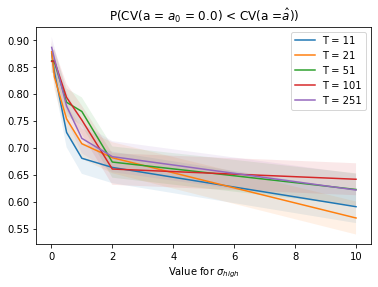

In [190]:
plt.xlabel(r"Value for $\sigma_{high}$")
plt.title(fr"P(CV(a = $a_0$ = {a}) < CV(a =" + r"$\hat{a}$))")
for i, a2_list in enumerate(total_list):
    plt.plot(a2_range, a2_list, label = f"T = {round(T_range[i], 2)}")
    plt.legend(loc = 1)
    
    dev = 1.96 * np.sqrt(np.array(a2_list) * (1 - np.array(a2_list)) / iters)
    plt.fill_between(a2_range, a2_list - dev, a2_list + dev, alpha = 0.1)

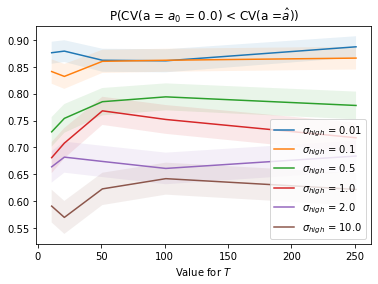

In [191]:
plt.xlabel(r"Value for $T$")
plt.title(fr"P(CV(a = $a_0$ = {a}) < CV(a =" + r"$\hat{a}$))")
for i, T_list in enumerate(np.array(total_list).T):
    T_list = np.array(T_list)
    plt.plot(T_range, T_list, label = r"$\sigma_{high}$ =" + f" {round(a2_range[i], 2)}")
    plt.legend()
    
    dev = 1.96 * np.sqrt(T_list * (1 - T_list) / iters)
    plt.fill_between(T_range, np.array(T_list) - dev, T_list + dev, alpha = 0.1)

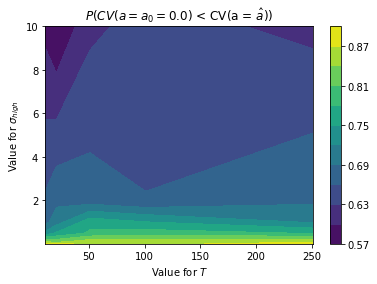

In [192]:
plt.xlabel(r"Value for $T$")
plt.ylabel(r"Value for $\sigma_{high}$")
plt.contourf(T_range, a2_range, np.array(total_list).T, levels = 10)
plt.colorbar()
plt.title(fr"$P(CV(a = a_0 = {a}$) < " + r"CV(a = $\hat{a}))$");